In [407]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [408]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 1.0}


1it [00:07,  7.09s/it]

n_sample_ratio=1.0


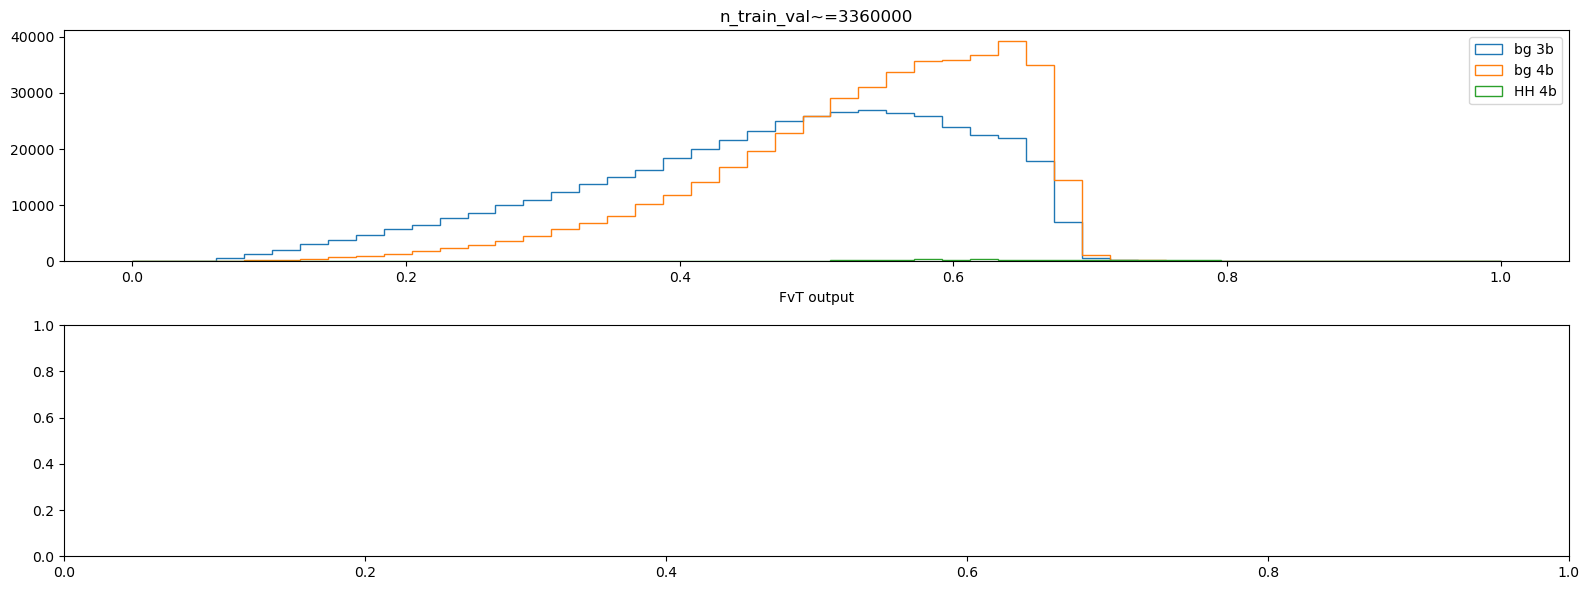

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 52, 'n_sample_ratio': 1.0}


1it [00:06,  6.50s/it]

n_sample_ratio=1.0


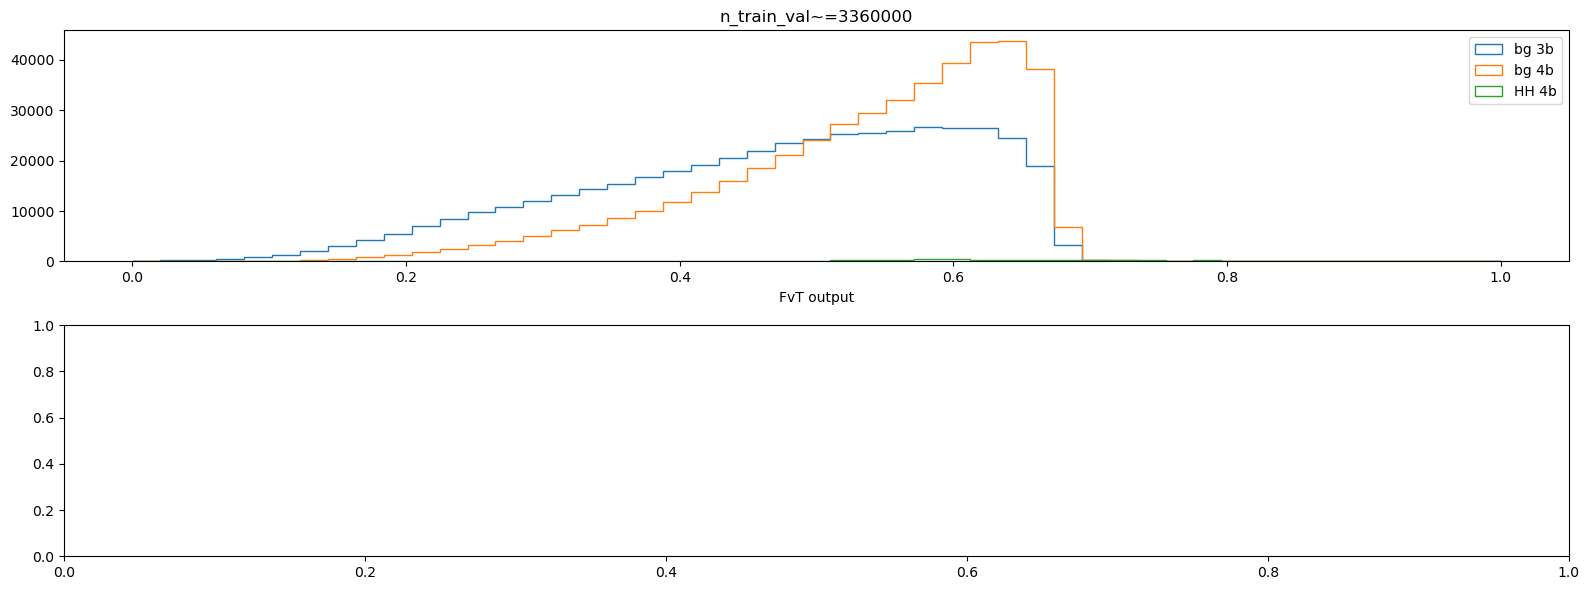

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 62, 'n_sample_ratio': 1.0}


1it [00:06,  6.79s/it]

n_sample_ratio=1.0


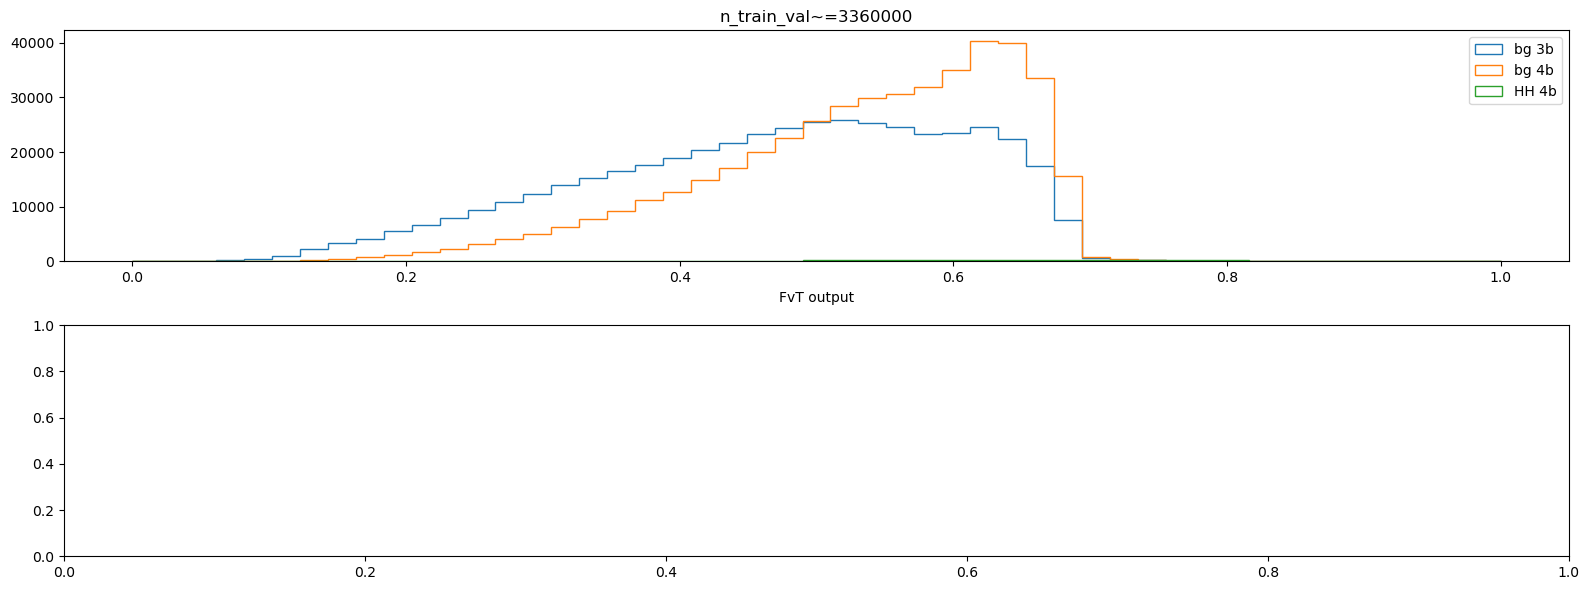

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 72, 'n_sample_ratio': 1.0}


1it [00:06,  6.63s/it]

n_sample_ratio=1.0


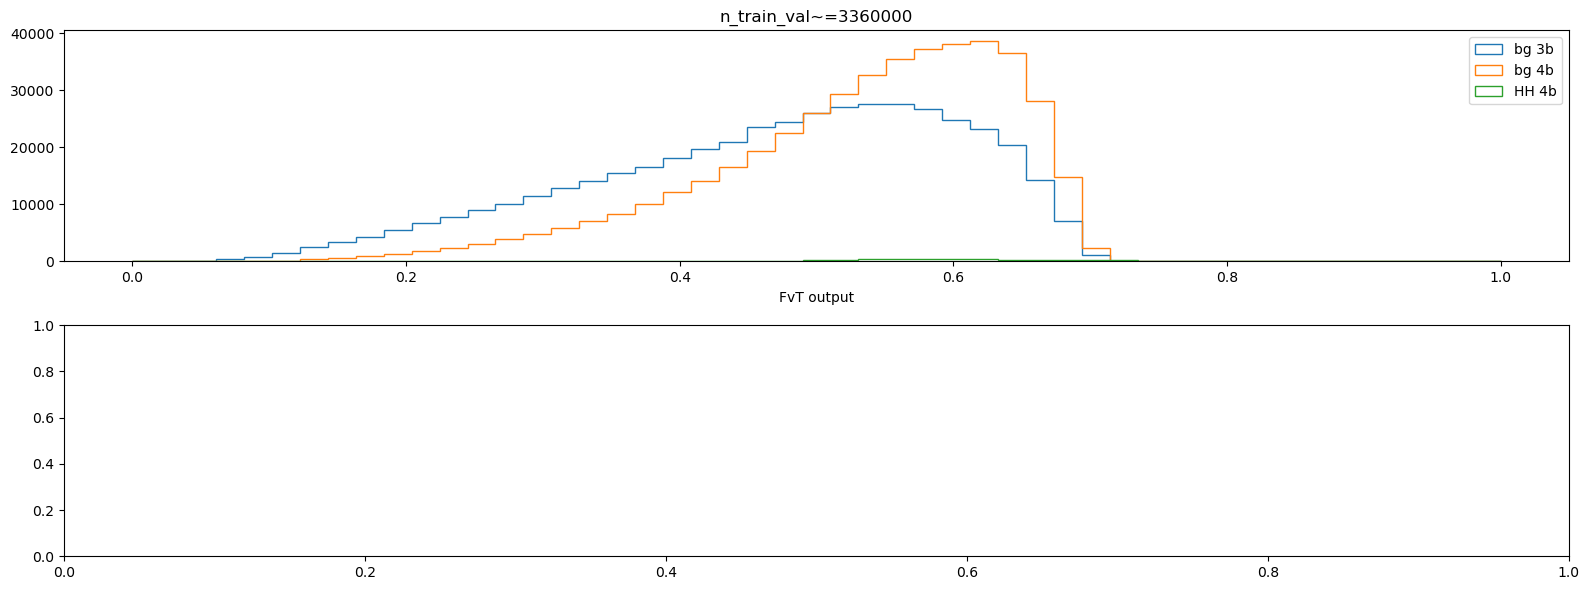

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 1.0}


1it [00:06,  6.57s/it]

n_sample_ratio=1.0


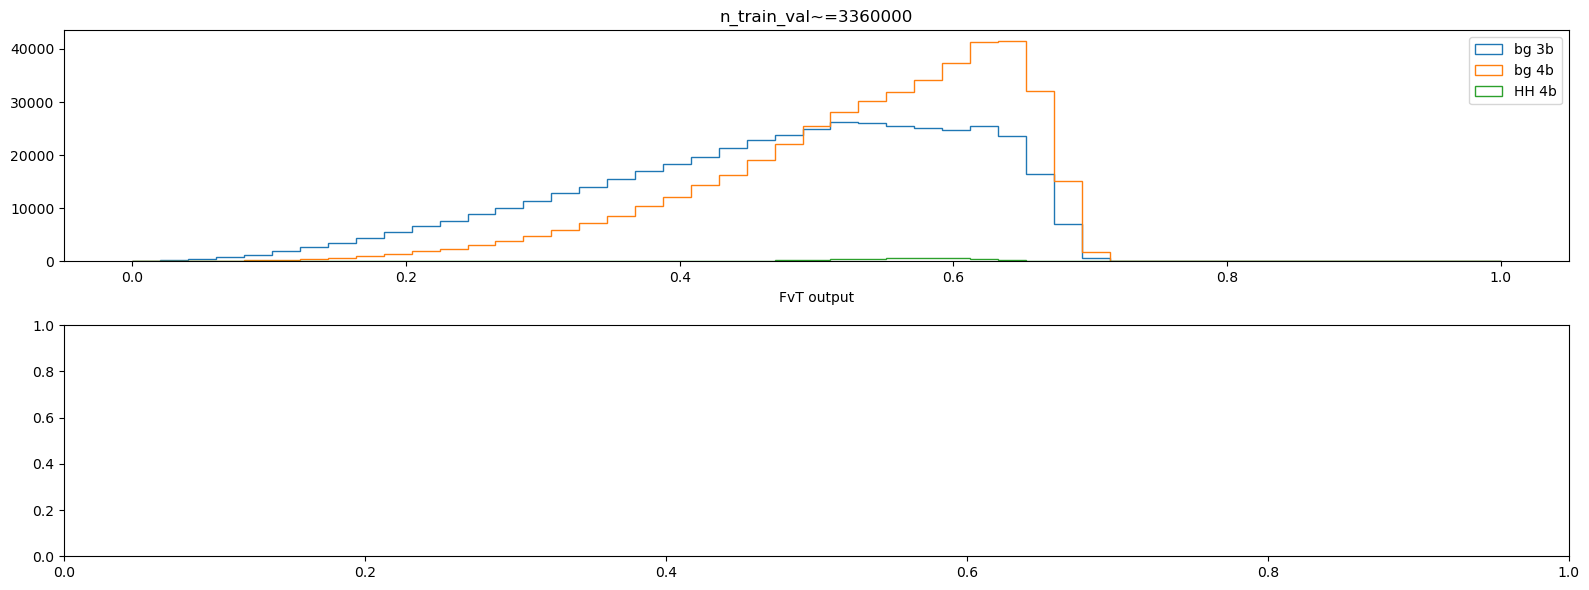

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 92, 'n_sample_ratio': 1.0}


1it [00:06,  6.91s/it]

n_sample_ratio=1.0


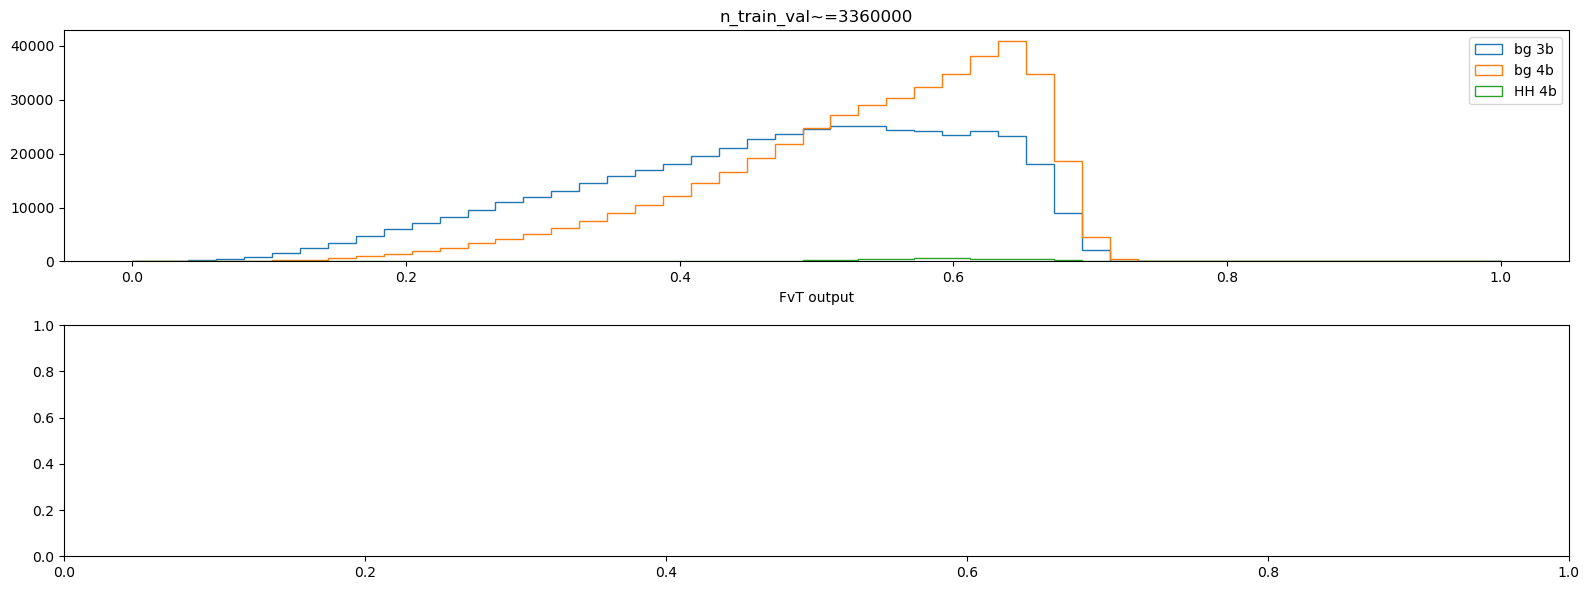

In [402]:
import torch
from dataset import generate_tt_dataset
from training_info import TrainingInfo
import pytorch_lightning as pl
import yaml
from fvt_classifier import FvTClassifier
from code_fragments import att_q_repr_hist, fvt_score_hist
from events_data import EventsData
import tqdm
import numpy as np
import matplotlib.pyplot as plt

config_filename = "configs/fvt_training_n_samples_1.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
# n_sample_ratios = config["n_sample_ratios"]
n_sample_ratios = [1.0]
seeds = [42, 52, 62, 72, 82, 92]
w_cuts = np.arange(0.01, 1.01, 0.01)

fvt_scores_dict = {seed: {} for seed in seeds}
att_q_reprs_dict = {seed: {} for seed in seeds}
events_test_dict = {}
is_in_regions_list_dict = {seed: {} for seed in seeds}
embeddings_dict = {seed: {} for seed in seeds}

for seed in seeds:
    _, dinfo_test = generate_tt_dataset(
            seed,
            n_3b,
            n_all4b,
            signal_ratio,
            test_ratio,
        )
    events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features)
    events_test_dict[seed] = events_test

    nrows = 2
    ncols = int(np.ceil(len(n_sample_ratios) / 2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

    for ax_cnt, n_sample_ratio in tqdm.tqdm(enumerate(n_sample_ratios)):
        hparam_filter = {"experiment_name": experiment_name, 
                         "seed": seed, 
                         "n_sample_ratio": n_sample_ratio}
        hashes = TrainingInfo.find(hparam_filter)
        assert len(hashes) == 1
        print("successfully loaded", hparam_filter)
        hash = hashes[0]
        tinfo = TrainingInfo.load(hash)

        current_ax = ax[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax[ax_cnt]
        current_ax.set_title(f"n_train_val~={1000 * ((len(tinfo.dinfo_train) + len(tinfo.dinfo_val)) // 1000)}")
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_test.set_model_scores(fvt_model)
        fvt_score_hist(events_test, current_ax)
        
        print(f"n_sample_ratio={n_sample_ratio}")
        # att_q_repr_hist(events_test, title=f"n_sample_ratio={n_sample_ratio}")

        fvt_scores_dict[seed][n_sample_ratio] = events_test.fvt_score
        att_q_reprs_dict[seed][n_sample_ratio] = events_test.att_q_repr

    fig.tight_layout()
    fig.show()

    plt.show()
    plt.close()

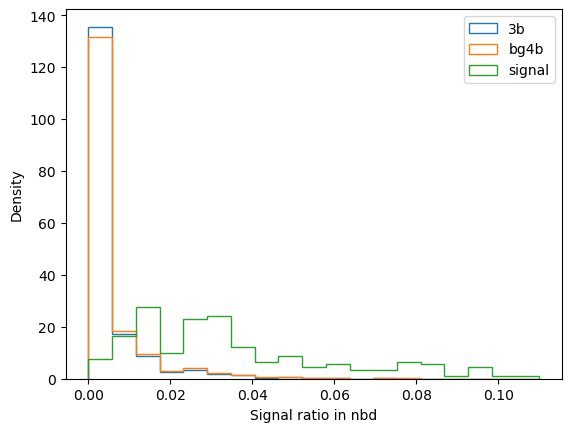

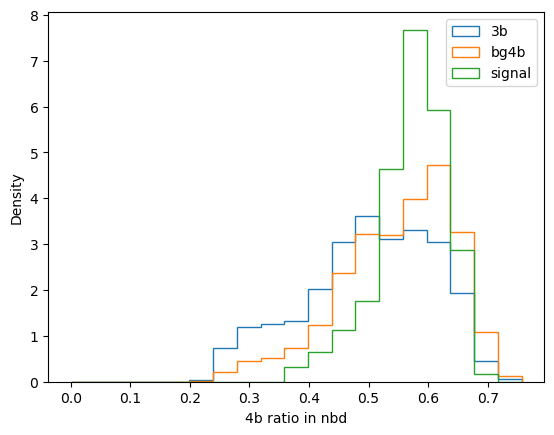

In [433]:
seed = 82
n_sample_ratio = 1.0

events = events_test_dict[seed]
X = events.att_q_repr.copy()

n_points = 30_000
idx = np.random.choice(X.shape[0], n_points, replace=False)
events_sampled = events[idx]
X = X[idx]

# calculate nearest neighbors for X
# from sklearn.neighbors import NearestNeighbors

from cuml.neighbors import NearestNeighbors
import cudf

pct = 0.01
n_neighbors = int(n_points * pct)
X_cudf = cudf.DataFrame(X)
model = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto", metric="euclidean")
nbrs = model.fit(X_cudf)
distances, indices = nbrs.kneighbors(X_cudf)
distances = distances.to_numpy()
indices = indices.to_numpy()

is_signal = events_sampled.is_signal
is_3b = events_sampled.is_3b
is_bg4b = events_sampled.is_bg4b
is_4b = events_sampled.is_4b

knn_signal_ratio = is_signal[indices].mean(axis=1)
knn_4b_ratio = is_4b[indices].mean(axis=1)

bins_range = np.linspace(0, np.max(knn_signal_ratio), 20)
plt.hist(knn_signal_ratio[is_3b], bins=bins_range, label="3b", density=True, histtype="step")
plt.hist(knn_signal_ratio[is_bg4b], bins=bins_range, label="bg4b", density=True, histtype="step")
plt.hist(knn_signal_ratio[is_signal], bins=bins_range, label="signal", density=True, histtype="step")
plt.xlabel("Signal ratio in nbd")
plt.ylabel("Density")
plt.legend()
plt.show()

bins_range = np.linspace(0, np.max(knn_4b_ratio), 20)
plt.hist(knn_4b_ratio[is_3b], bins=bins_range, label="3b", density=True, histtype="step")
plt.hist(knn_4b_ratio[is_bg4b], bins=bins_range, label="bg4b", density=True, histtype="step")
plt.hist(knn_4b_ratio[is_signal], bins=bins_range, label="signal", density=True, histtype="step")
plt.xlabel("4b ratio in nbd")
plt.ylabel("Density")
plt.legend()
plt.show()



In [327]:
rho = fvt_scores_dict[seed][n_sample_ratio][idx]
X = att_q_reprs_dict[seed][n_sample_ratio][idx]
min_dists = np.zeros(n_points)
# dist_matrix = squareform(pdist(X, 'euclidean'))
rho_argsort = np.argsort(rho)[::-1]

dist_func = lambda x, y: np.linalg.norm(x - y, axis=1)

# can be parallelized

import multiprocessing as mp

def min_dist_fn(i):
    if i == 0:
        return np.inf
    else:
        return np.min(dist_func(X[rho_argsort[i]], X[rho_argsort[:i]]))

n_workers = 8
with mp.Pool(n_workers) as pool:
    min_dists = np.array(pool.map(min_dist_fn, np.arange(n_points)))

min_dists[rho_argsort] = min_dists.copy()
min_dists[np.isinf(min_dists)] = np.max(min_dists[~np.isinf(min_dists)]) # replace inf with max

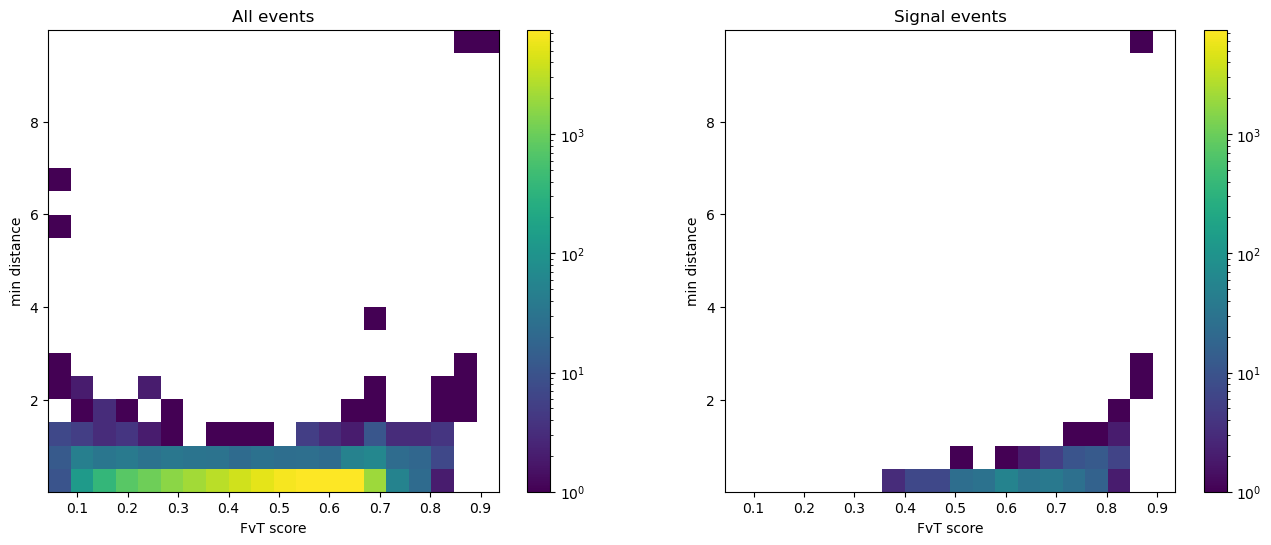

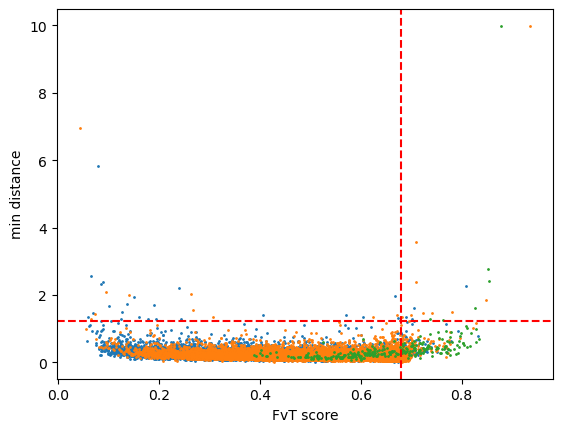

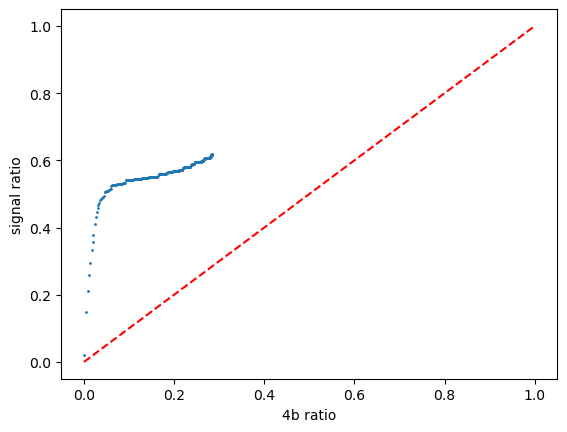

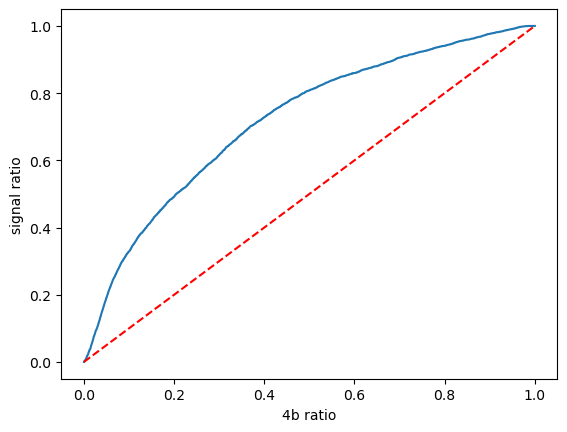

In [380]:
import matplotlib
import pandas as pd

rho_cut = np.quantile(rho, 0.98)
min_dist_cut = np.quantile(min_dists[rho > rho_cut], 0.98)

# log scale histogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
hist_all, x_bins, y_bins, im = ax[0].hist2d(rho, min_dists, bins=20, norm=matplotlib.colors.LogNorm())
vmin = max(1, hist_all.min())
vmax = hist_all.max()
fig.colorbar(im, ax=ax[0])
ax[0].set_title("All events")
ax[0].set_xlabel("FvT score")
ax[0].set_ylabel("min distance")

# use same color scale
_, _, _, im = ax[1].hist2d(rho[is_signal], min_dists[is_signal], bins=(x_bins, y_bins), norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(im, ax=ax[1])
ax[1].set_title("Signal events")
ax[1].set_xlabel("FvT score")
ax[1].set_ylabel("min distance")
plt.show()

plt.plot(rho[is_3b], min_dists[is_3b], 'o', label="3b", markersize=1)
plt.plot(rho[is_bg4b], min_dists[is_bg4b], 'o', label="bg4b", markersize=1)
plt.plot(rho[is_signal], min_dists[is_signal], 'o', label="signal", markersize=1)
plt.axhline(min_dist_cut, color="red", linestyle="--")
plt.axvline(rho_cut, color="red", linestyle="--")
plt.xlabel("FvT score")
plt.ylabel("min distance")
plt.show()

peaks = np.argwhere((rho > rho_cut) & (min_dists > min_dist_cut)).flatten()

peaks_df = pd.DataFrame({"rho": rho[peaks], 
                         "min_dist": min_dists[peaks], 
                         "is_3b": is_3b[peaks], 
                         "is_bg4b": is_bg4b[peaks], 
                         "is_signal": is_signal[peaks], 
                         "is_4b": is_4b[peaks], 
                         "knn_signal_ratio": knn_signal_ratio[peaks],
                         "knn_4b_ratio": knn_4b_ratio[peaks]})

plt.plot(
    [is_4b[np.unique(indices[peaks, :k])].sum() / np.sum(is_4b) for k in range(1, n_neighbors, 10)],
    [is_signal[np.unique(indices[peaks, :k])].sum() / np.sum(is_signal) for k in range(1, n_neighbors, 10)],
    'o', 
    markersize=1
)

plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("4b ratio")
plt.ylabel("signal ratio")
plt.show()

X_all = att_q_reprs_dict[seed][n_sample_ratio]

dists_to_nearest_peak = np.min([dist_func(X_all, X[peak]) for peak in peaks], axis=0)
dists_to_nearest_peak_argsort = np.argsort(dists_to_nearest_peak)

plt.plot(events.is_4b[dists_to_nearest_peak_argsort].cumsum() / events.is_4b.sum(), 
        events.is_signal[dists_to_nearest_peak_argsort].cumsum() / events.is_signal.sum())
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("4b ratio")
plt.ylabel("signal ratio")
plt.show()


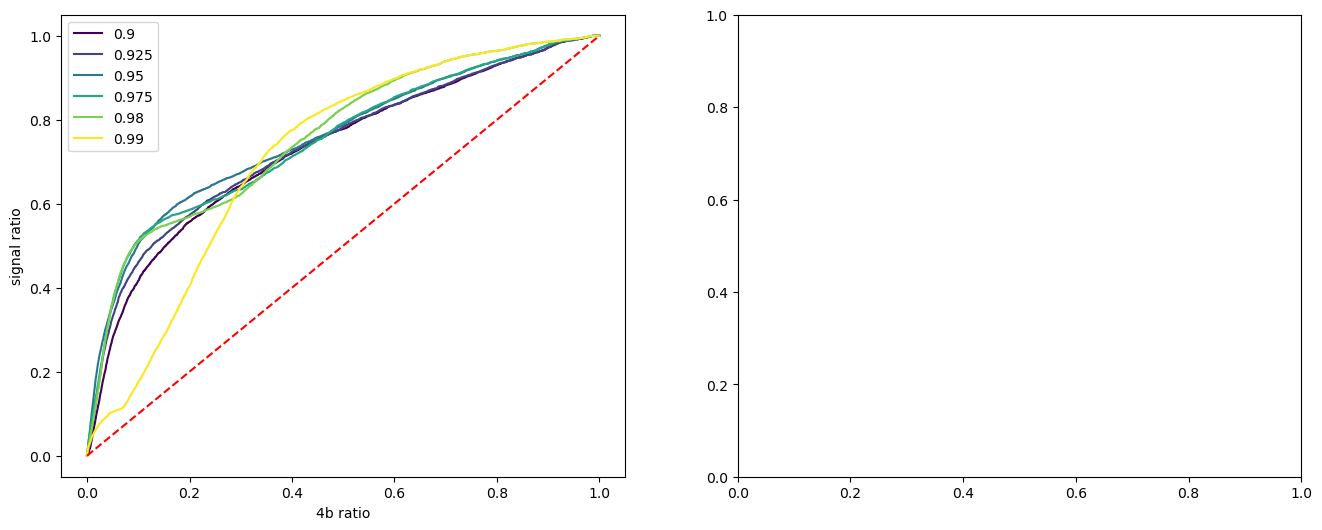

In [401]:
import matplotlib
import pandas as pd


quantile_cuts = [0.9, 0.925, 0.95, 0.975, 0.98, 0.99]
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, len(quantile_cuts))]
events_rest = events[np.setdiff1d(np.arange(len(events)), idx)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for color_i, quantile_cut in enumerate(quantile_cuts):
    rho_cut = np.quantile(rho, quantile_cut)
    min_dist_cut = np.quantile(min_dists[rho > rho_cut], quantile_cut)

    peaks = np.argwhere((rho > rho_cut) & (min_dists > min_dist_cut)).flatten()    
    dists_to_nearest_peak = np.min([dist_func(events_rest.att_q_repr, X[peak]) / distances[peak].mean() for peak in peaks], axis=0)
    dists_to_nearest_peak_argsort = np.argsort(dists_to_nearest_peak)

    ax[0].plot(events_rest.is_4b[dists_to_nearest_peak_argsort].cumsum() / events_rest.is_4b.sum(), 
            events_rest.is_signal[dists_to_nearest_peak_argsort].cumsum() / events_rest.is_signal.sum(), 
            color=colors[color_i], label=f"{quantile_cut}")

ax[0].plot([0, 1], [0, 1], color="red", linestyle="--")
ax[0].set_xlabel("4b ratio")
ax[0].set_ylabel("signal ratio")
ax[0].legend()
plt.show()



6it [01:55, 19.26s/it]


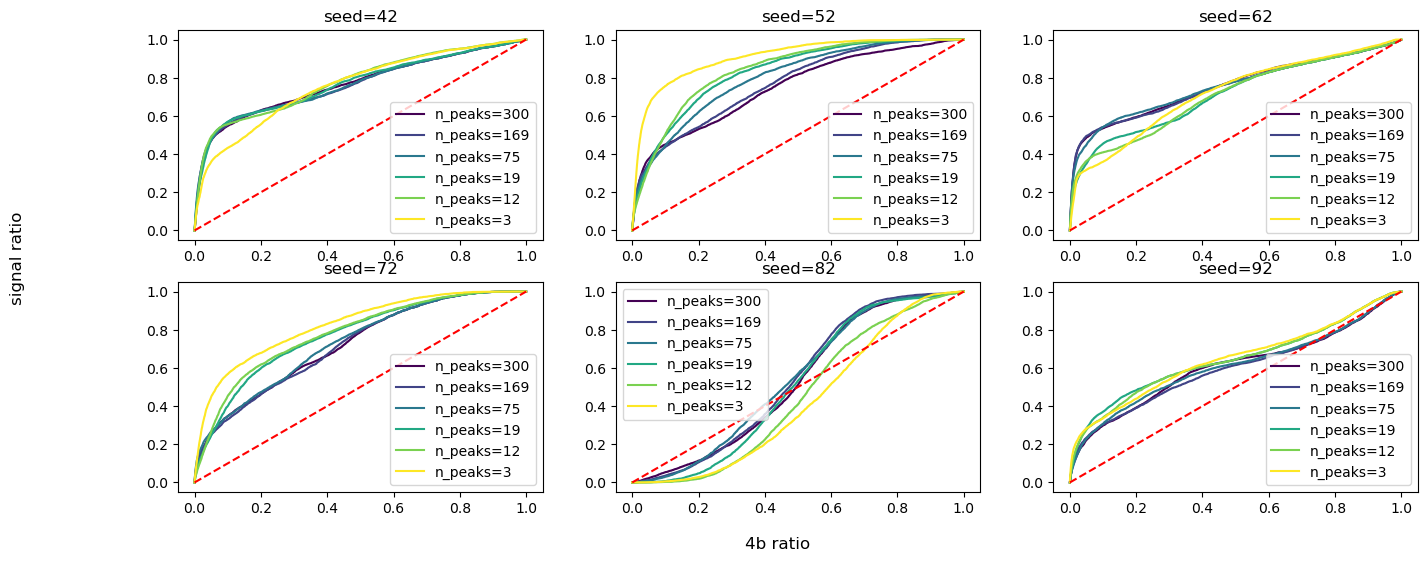

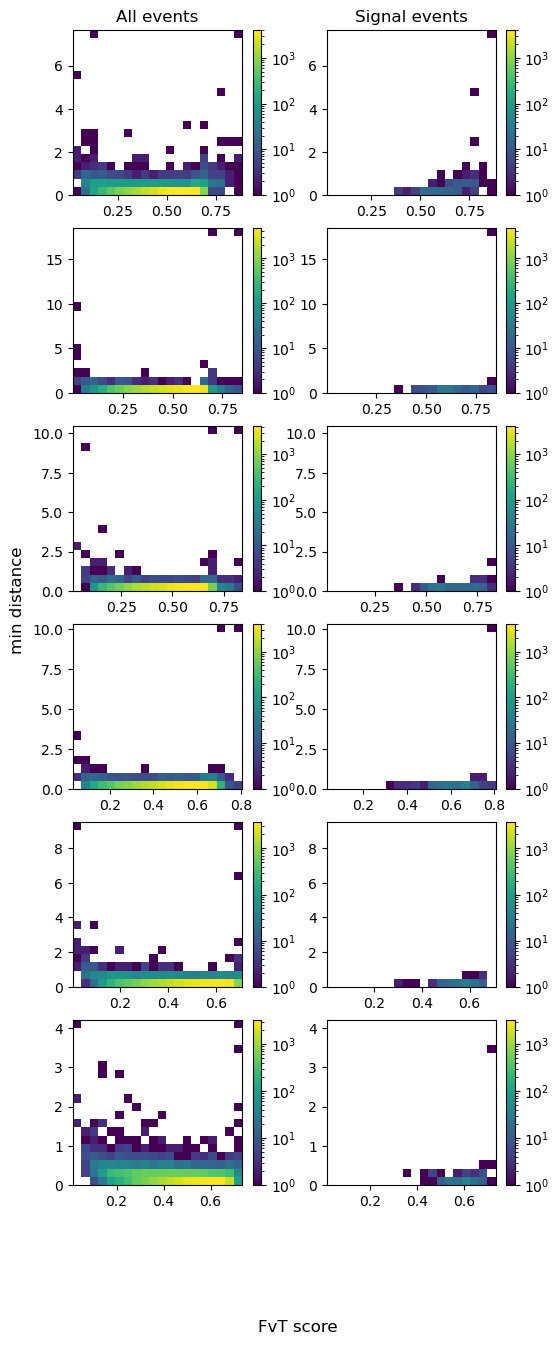

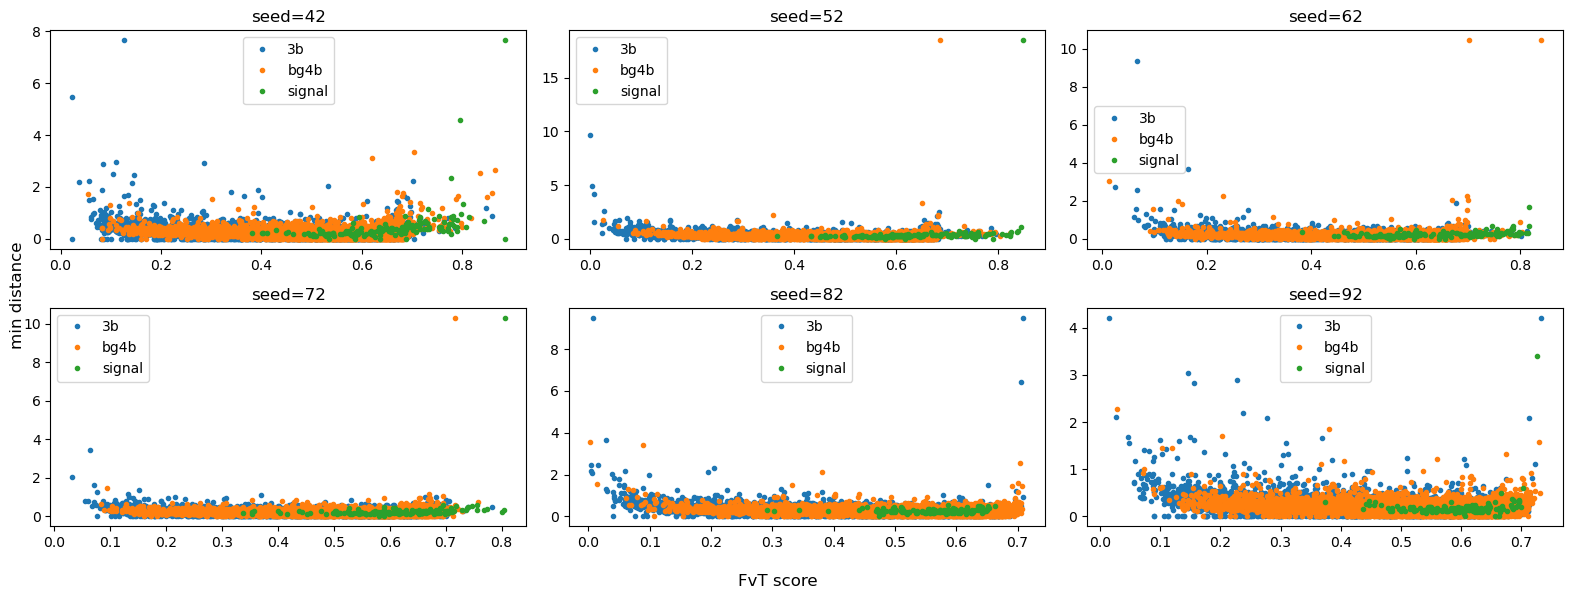

In [416]:
n_sample_ratio = 1.0
nrows, ncols = 2, 3
n_points = 30_000
pct = 0.01
n_workers = 8
quantile_cuts = [0.9, 0.925, 0.95, 0.975, 0.98, 0.99]

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
fig.supxlabel("4b ratio")
fig.supylabel("signal ratio")

fig2, ax2 = plt.subplots(nrows=len(seeds), ncols=2, figsize=(6, 15))
fig2.supxlabel("FvT score")
fig2.supylabel("min distance")

fig3, ax3 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
fig3.supxlabel("FvT score")
fig3.supylabel("min distance")

peaks_dict = {seed: {} for seed in seeds}
events_sampled_dict = {}

    
for ax_cnt, seed in tqdm.tqdm(enumerate(seeds)):
    np.random.seed(seed)
    events = events_test_dict[seed]
    X = events.att_q_repr.copy()
    idx = np.random.choice(X.shape[0], n_points, replace=True, p=events.weights / events.weights.sum())
    events_sampled = events[idx]
    X = X[idx]

    
    n_neighbors = int(n_points * pct)
    X_cudf = cudf.DataFrame(X)
    model = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto", metric="euclidean")
    nbrs = model.fit(X_cudf)
    distances, indices = nbrs.kneighbors(X_cudf)
    distances = distances.to_numpy()
    indices = indices.to_numpy()

    rho = fvt_scores_dict[seed][n_sample_ratio][idx]
    min_dists = np.zeros(n_points)
    rho_argsort = np.argsort(rho)[::-1]
    dist_func = lambda x, y: np.linalg.norm(x - y, axis=1)

    def min_dist_fn(i):
        if i == 0:
            return np.inf
        else:
            return np.min(dist_func(X[rho_argsort[i]], X[rho_argsort[:i]]))

    
    with mp.Pool(n_workers) as pool:
        min_dists = np.array(pool.map(min_dist_fn, np.arange(n_points)))

    min_dists[rho_argsort] = min_dists.copy()
    min_dists[np.isinf(min_dists)] = np.max(min_dists[~np.isinf(min_dists)]) # replace inf with max

    hist_all, x_bins, y_bins, im = ax2[ax_cnt, 0].hist2d(rho, min_dists, bins=20, norm=matplotlib.colors.LogNorm())
    vmin = max(1, hist_all.min())
    vmax = hist_all.max()
    fig2.colorbar(im, ax=ax2[ax_cnt, 0])
    if ax_cnt == 0: 
        ax2[ax_cnt, 0].set_title("All events")
    

    # use same color scale
    _, _, _, im = ax2[ax_cnt, 1].hist2d(rho[events_sampled.is_signal], min_dists[events_sampled.is_signal], bins=(x_bins, y_bins), norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    fig2.colorbar(im, ax=ax2[ax_cnt, 1])
    if ax_cnt == 0:
        ax2[ax_cnt, 1].set_title("Signal events")
    
    current_ax3 = ax3[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax3[ax_cnt]
    current_ax3.set_title(f"seed={seed}")
    current_ax3.plot(rho[events_sampled.is_3b], min_dists[events_sampled.is_3b], 'o', label="3b", markersize=3)
    current_ax3.plot(rho[events_sampled.is_bg4b], min_dists[events_sampled.is_bg4b], 'o', label="bg4b", markersize=3)
    current_ax3.plot(rho[events_sampled.is_signal], min_dists[events_sampled.is_signal], 'o', label="signal", markersize=3)
    current_ax3.legend()
    
    
    cmap = plt.get_cmap("viridis")
    colors = [cmap(i) for i in np.linspace(0, 1, len(quantile_cuts))]
    events_rest = events[np.setdiff1d(np.arange(len(events)), idx)]

    current_ax = ax[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax[ax_cnt]
    current_ax.set_title(f"seed={seed}")

    for color_i, quantile_cut in enumerate(quantile_cuts):
        rho_cut = np.quantile(rho, quantile_cut)
        min_dist_cut = np.quantile(min_dists[rho > rho_cut], quantile_cut)

        peaks = np.argwhere((rho > rho_cut) & (min_dists > min_dist_cut)).flatten()    
        
        peaks_dict[seed][quantile_cut] = peaks
        events_sampled_dict[seed] = events_sampled.clone()
        dists_to_nearest_peak = np.min([dist_func(events_rest.att_q_repr, X[peak]) / distances[peak].mean() for peak in peaks], axis=0)
        dists_to_nearest_peak_argsort = np.argsort(dists_to_nearest_peak)

        current_ax.plot(events_rest.is_4b[dists_to_nearest_peak_argsort].cumsum() / events_rest.is_4b.sum(), 
                events_rest.is_signal[dists_to_nearest_peak_argsort].cumsum() / events_rest.is_signal.sum(), 
                color=colors[color_i], label=f"n_peaks={len(peaks)}")

    current_ax.plot([0, 1], [0, 1], color="red", linestyle="--")
    current_ax.legend()

plt.tight_layout()
plt.show()

In [426]:
print("Number of signal events in peaks")
display(pd.DataFrame({
    quantile_cut: ["{} / {}".format(
        events_sampled_dict[seed].is_signal[peaks_dict[seed][quantile_cut]].sum(),
        len(peaks_dict[seed][quantile_cut])
    ) for seed in seeds] for quantile_cut in quantile_cuts
}, index=seeds))

Number of signal events in peaks


,0.900,0.925,0.950,0.975,0.980,0.990
42,46 / 300,31 / 169,17 / 75,4 / 19,3 / 12,2 / 3
52,28 / 300,18 / 169,10 / 75,2 / 19,2 / 12,1 / 3
62,33 / 300,23 / 169,13 / 75,2 / 19,1 / 12,0 / 3
72,17 / 300,15 / 169,10 / 75,3 / 19,1 / 12,1 / 3
82,3 / 300,1 / 169,0 / 75,0 / 19,0 / 12,0 / 3
92,9 / 300,8 / 169,4 / 75,2 / 19,2 / 12,1 / 3


  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 125/125 [00:00<00:00, 472.41it/s]


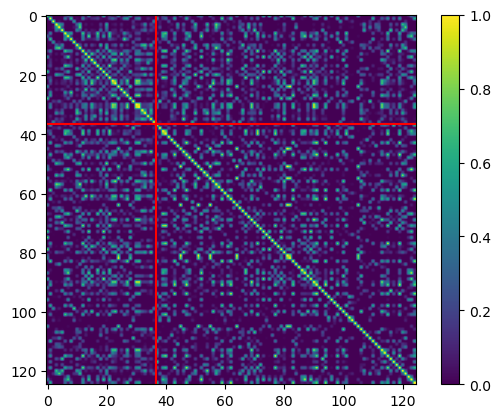

In [311]:
shared_neighbors = np.ones((len(peaks), len(peaks)))

for i in tqdm.tqdm(range(len(peaks))):
    for j in range(i + 1, len(peaks)):
        shared_neighbors[i, j] = np.intersect1d(indices[peaks[i]], indices[peaks[j]]).shape[0] / n_neighbors
        shared_neighbors[j, i] = shared_neighbors[i, j]

peaks_sorted_idx = np.argsort(peaks_df.is_signal)[::-1]

plt.imshow(shared_neighbors[peaks_sorted_idx][:, peaks_sorted_idx], cmap="viridis")
plt.axhline(np.sum(peaks_df.is_signal) + 0.5, color="red")
plt.axvline(np.sum(peaks_df.is_signal) + 0.5, color="red")
plt.colorbar()
plt.show()

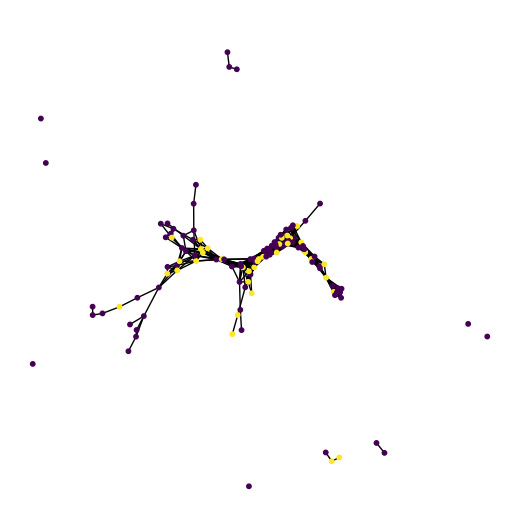

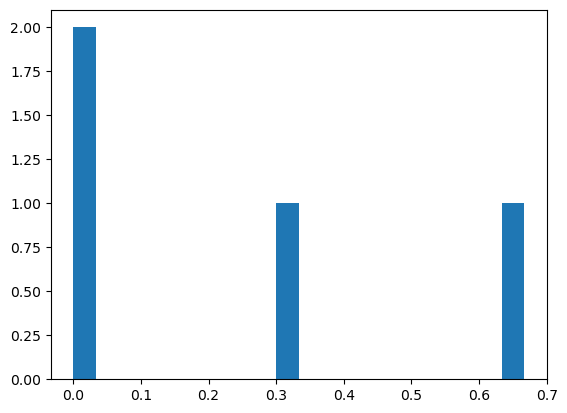

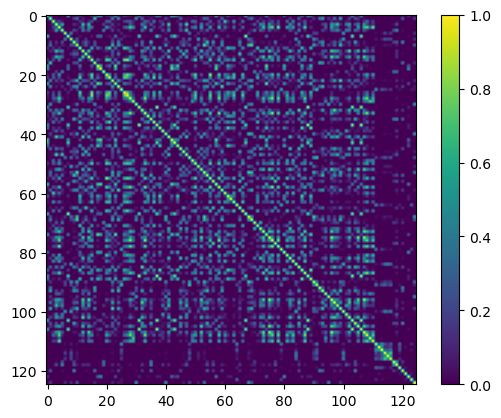

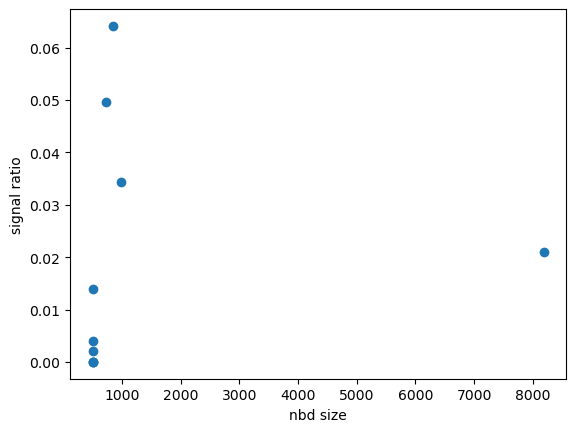

In [310]:
# Define i, j to be connected (or form an edge) if they share at least 0.5 of their neighbors

import networkx as nx

G = nx.Graph()
G.add_nodes_from(range(len(peaks)))

for i in range(len(peaks)):
    for j in range(i + 1, len(peaks)):
        if shared_neighbors[i, j] > 0.5:
            G.add_edge(i, j)

plt.figure(figsize=(5, 5))
node_color = peaks_df.is_signal.astype(int)
nx.draw(G, with_labels=False, node_color=node_color, cmap="viridis", node_size=10)
plt.show()

# get connected components
connected_components = list(nx.connected_components(G))

plt.hist([peaks_df.is_signal[list(cc)].mean() for cc in connected_components if len(cc) > 1], bins=20)
plt.show()

# sort by connected_components
connected_components_sorted = sorted(connected_components, key=lambda cc: len(cc), reverse=True)
peaks_sorted_idx = np.concatenate([list(cc) for cc in connected_components_sorted])

plt.imshow(shared_neighbors[peaks_sorted_idx][:, peaks_sorted_idx], cmap="viridis")
plt.colorbar()
plt.show()

# for each connected component, get size of union of nearest neighbors

union_neighbors = []

for cc_i, cc in enumerate(connected_components):
    cc_neighbors = set()
    for i in cc:
        cc_neighbors = cc_neighbors.union(set(indices[peaks[i]]))
    union_neighbors.append(np.array(list(cc_neighbors)))

plt.plot([len(nbd) for nbd in union_neighbors], 
         [is_signal[nbd].mean() for nbd in union_neighbors], 
         'o')
plt.xlabel("nbd size")
plt.ylabel("signal ratio")
plt.show()

In [275]:
# kernel density estimation

from cuml.neighbors import KernelDensity

# cross validation
bandwidths = np.linspace(0.01, 0.5, 20)

from cuml.model_selection import GridSearchCV as cuGridSearchCV

kde = KernelDensity()
params = {"bandwidth": bandwidths, "kernel": ["gaussian"]}
grid = cuGridSearchCV(kde, params)
grid.fit(X_cudf)

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.01      , 0.03578947, 0.06157895, 0.08736842, 0.11315789,
       0.13894737, 0.16473684, 0.19052632, 0.21631579, 0.24210526,
       0.26789474, 0.29368421, 0.31947368, 0.34526316, 0.37105263,
       0.39684211, 0.42263158, 0.44842105, 0.47421053, 0.5       ]),
                         'kernel': ['gaussian']})

In [276]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'bandwidth': 0.1131578947368421, 'kernel': 'gaussian'}
-25605.921941176555
KernelDensity()


In [277]:
kde = KernelDensity(bandwidth=grid.best_params_["bandwidth"], kernel=grid.best_params_["kernel"])
# kde = KernelDensity(bandwidth=0.1, kernel="gaussian")
kde.fit(X_cudf)

n_chunks = 5
kde_scores = np.zeros(n_points)

for i in range(n_chunks):
    chunk = slice(i * n_points // n_chunks, (i + 1) * n_points // n_chunks)
    kde_scores[chunk] = kde.score_samples(X_cudf[chunk]).get()

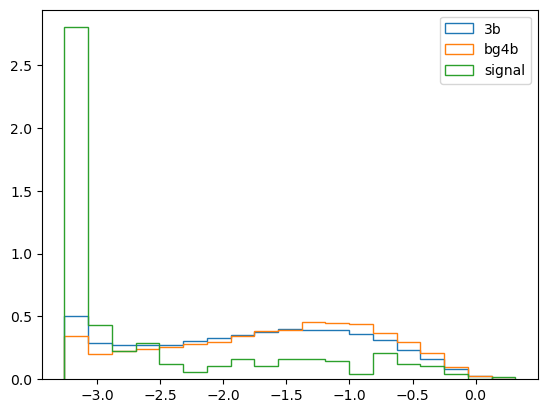

In [278]:
bins_range = np.linspace(np.min(kde_scores), np.max(kde_scores), 20)
plt.hist(kde_scores[is_3b], bins=bins_range, label="3b", density=True, histtype="step")
plt.hist(kde_scores[is_bg4b], bins=bins_range, label="bg4b", density=True, histtype="step")
plt.hist(kde_scores[is_signal], bins=bins_range, label="signal", density=True, histtype="step")
plt.legend()
plt.show()

In [279]:
min_dists = np.zeros(n_points)
# dist_matrix = squareform(pdist(X, 'euclidean'))
kde_score_argsort = np.argsort(kde_scores)[::-1]

dist_func = lambda x, y: np.linalg.norm(x - y, axis=1)

# can be parallelized

import multiprocessing as mp

def min_dist_fn(i):
    if i == 0:
        return np.inf
    else:
        return np.min(dist_func(X[kde_score_argsort[i]], X[kde_score_argsort[:i]]))

n_workers = 8
with mp.Pool(n_workers) as pool:
    min_dists = np.array(pool.map(min_dist_fn, np.arange(n_points)))

min_dists[kde_score_argsort] = min_dists.copy()
min_dists[np.isinf(min_dists)] = np.max(min_dists[~np.isinf(min_dists)]) # replace inf with max

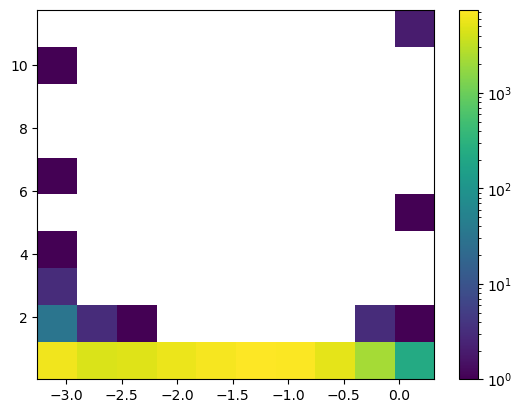

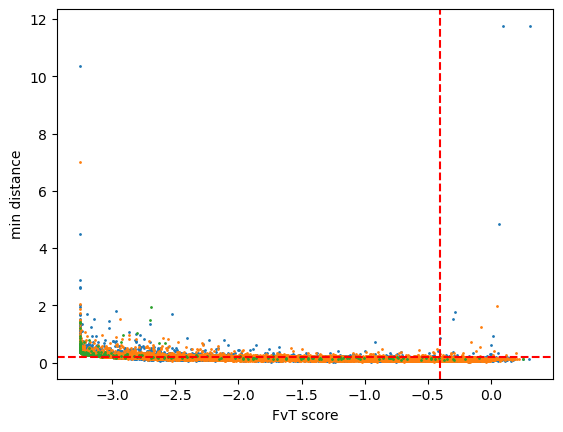

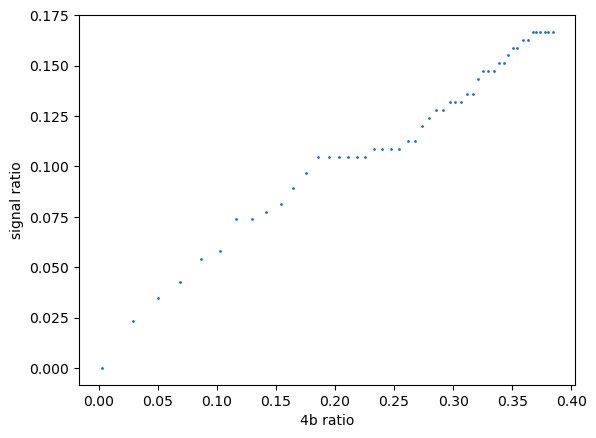

In [280]:
kde_score_cut = np.quantile(kde_scores, 0.95)
min_dist_cut = np.quantile(min_dists[kde_scores > kde_score_cut], 0.95)

# log scale histogram
plt.hist2d(kde_scores, min_dists, bins=10, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

plt.plot(kde_scores[is_3b], min_dists[is_3b], 'o', label="3b", markersize=1)
plt.plot(kde_scores[is_bg4b], min_dists[is_bg4b], 'o', label="bg4b", markersize=1)
plt.plot(kde_scores[is_signal], min_dists[is_signal], 'o', label="signal", markersize=1)
plt.axhline(min_dist_cut, color="red", linestyle="--")
plt.axvline(kde_score_cut, color="red", linestyle="--")
plt.xlabel("FvT score")
plt.ylabel("min distance")
plt.show()

peaks = np.argwhere((kde_scores > kde_score_cut) & (min_dists > min_dist_cut)).flatten()

peaks_df = pd.DataFrame({"kde_scores": kde_scores[peaks], 
                         "min_dist": min_dists[peaks], 
                         "is_3b": is_3b[peaks], 
                         "is_bg4b": is_bg4b[peaks], 
                         "is_signal": is_signal[peaks], 
                         "is_4b": is_4b[peaks], 
                         "knn_signal_ratio": knn_signal_ratio[peaks],
                         "knn_4b_ratio": knn_4b_ratio[peaks]})

plt.plot(
    [is_4b[np.unique(indices[peaks, :k])].sum() / np.sum(is_4b) for k in range(1, n_neighbors, 10)],
    [is_signal[np.unique(indices[peaks, :k])].sum() / np.sum(is_signal) for k in range(1, n_neighbors, 10)],
    'o', 
    markersize=1
)
plt.xlabel("4b ratio")
plt.ylabel("signal ratio")
plt.show()

In [185]:
peaks = np.argwhere((rho > 0.7) & (min_dists > 1.5)).reshape(-1)



# pct = 0.02
# k = int(n_points * pct)
# cmap = plt.get_cmap("tab10")

# for peak in peaks:
#     print("++++++++++++++++++++++++++++++")
#     print(peak)
#     color = cmap(0 if is_3b[peak] else 1 if is_bg4b[peak] else 2)
#     plt.plot(rho[is_3b], min_dists[is_3b], 'o', label="3b", markersize=1)
#     plt.plot(rho[is_bg4b], min_dists[is_bg4b], 'o', label="bg4b", markersize=1)
#     plt.plot(rho[is_signal], min_dists[is_signal], 'o', label="signal", markersize=1)
#     plt.plot(rho[peak], min_dists[peak], 'x', label="peak", markersize=10, color=color)
#     plt.xlabel("FvT score")
#     plt.ylabel("min distance")
#     plt.show()


#     dists = dist_func(X[peak], X)
#     closest = np.argsort(dists)[:k]
#     closest_bool = np.zeros(n_points, dtype=bool)
#     closest_bool[closest] = True

#     closest_3b = np.argwhere(is_3b[closest]).reshape(-1)
#     closest_bg4b = np.argwhere(is_bg4b[closest]).reshape(-1)
#     closest_signal = np.argwhere(is_signal[closest]).reshape(-1)

#     plt.plot(dists[closest][closest_3b], np.cumsum(is_3b[closest])[closest_3b] / np.sum(is_3b), label="3b", marker="x")
#     plt.plot(dists[closest][closest_bg4b], np.cumsum(is_bg4b[closest])[closest_bg4b] / np.sum(is_bg4b), label="bg4b", marker="x")
#     plt.plot(dists[closest][closest_signal], np.cumsum(is_signal[closest])[closest_signal] / np.sum(is_signal), label="signal", marker="x")
#     ax2 = plt.gca().twinx()
#     ax2.plot(dists[closest], np.cumsum(is_signal[closest]) / np.cumsum(is_4b[closest]))
#     plt.legend()
#     plt.show()

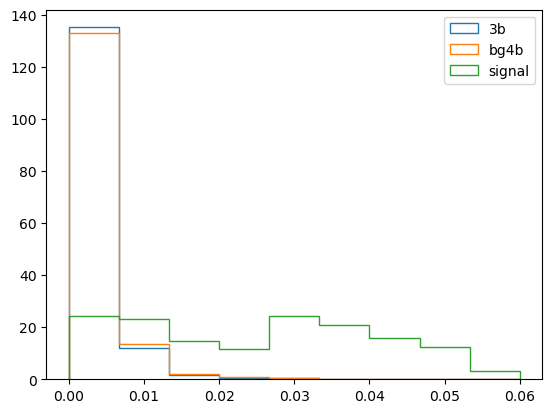